In [1]:
import gammapy
print(gammapy.__version__)

import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from gammapy.data import DataStore, Observation
from gammapy.datasets import MapDataset
from gammapy.maps import MapAxis, WcsGeom, Map
from gammapy.makers import MapDatasetMaker
from gammapy.makers.utils import make_edisp_map, make_edisp_kernel_map
from gammapy.irf import EnergyDispersion2D
from utils import EdispInv

from gammapy.modeling.models import (
    Model,
    Models,
    SkyModel,
    PowerLawSpectralModel,
    PowerLawNormSpectralModel,
    PointSpatialModel,
    TemplateSpatialModel,
    ExpDecayTemporalModel,
    LightCurveTemplateTemporalModel,
    FoVBackgroundModel,
    GaussianSpatialModel,
    LogParabolaSpectralModel,
    DatasetModels
)

0.20.1


## Create a MapDatset

In [2]:
data_store = DataStore.from_dir("$GAMMAPY_DATA/hess-dl3-dr1")
obs_id = [23523] # just one observation 
obs1 = data_store.get_observations(obs_id)[0]

In [3]:
crab_pos = SkyCoord(184.557, -5.784, unit='deg', frame='galactic') 
obs_pos=obs1.pointing_radec
ebins = np.logspace(-1,2,49)
energy_axis = MapAxis.from_edges(
    ebins, unit="TeV", name="energy", interp="log"  
)
energy_axis_true = MapAxis.from_edges(
    ebins, unit="TeV", name="energy_true", interp="log"  
)
migra_axis = MapAxis.from_bounds(
    0.2, 5, nbin=160, node_type="edges", name="migra"
)
geom = WcsGeom.create(
    skydir=obs_pos,
    binsz=0.02,
    width=(3.5, 3.5),
    frame="icrs",
    proj="CAR",
    axes=[energy_axis],
)

In [4]:
%%time
maker = MapDatasetMaker(selection=['edisp', 'exposure'])
reference = MapDataset.create(geom=geom, energy_axis_true=energy_axis_true, migra_axis=migra_axis)  #, migra_axis=migra_axis

dataset = maker.run(reference, obs1)

CPU times: user 1.14 s, sys: 146 ms, total: 1.29 s
Wall time: 1.31 s


## EdispKernel Generation
Check how Gammapy generates the EdispKernel from the Edisp2D

In [94]:
kernel_from_ds = dataset.edisp.get_edisp_kernel(energy_axis)
kernel_from_edisp2d = obs1.edisp.to_edisp_kernel(0.1*u.deg,
                                                 energy_true=energy_axis.edges, 
                                                 energy = energy_axis.edges)

In [95]:
e_energy=[1,2,3,3.4,4,50,60,72]*u.TeV
event_kernels = obs1.edisp.to_edisp_kernel(0.1*u.deg,
                 energy_true=energy_axis.edges, 
                 energy = e_energy)

<AxesSubplot:xlabel='True Energy [TeV]', ylabel='Energy [TeV]'>

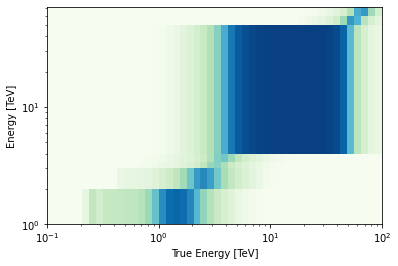

In [96]:
event_kernels.plot_matrix()

In [97]:
event_kernels.pdf_matrix.shape, e_energy.shape

((48, 7), (8,))

Text(0, 0.5, 'PDF Matrix Entry')

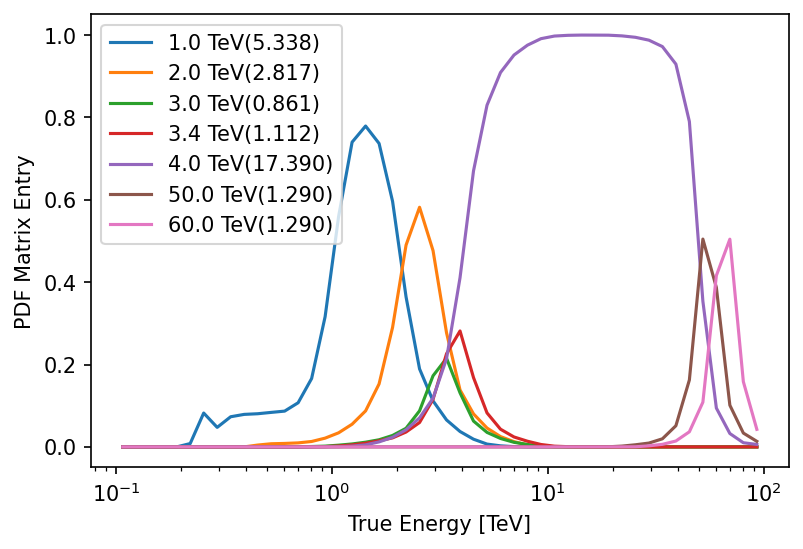

In [98]:
plt.figure(dpi=150)
for i,e in enumerate(e_energy[:-1]):
    ker=event_kernels.pdf_matrix[:,i]
    plt.semilogx(event_kernels.axes[0].center, ker, label=f"{e}({ker.sum():.3f})")
    
plt.legend()
plt.xlabel("True Energy [TeV]")
plt.ylabel("PDF Matrix Entry")

In [99]:
new_geom = geom.downsample(25).to_image().to_cube([migra_axis, energy_axis_true])

edisp_map = make_edisp_map(obs1.edisp, obs_pos, new_geom)

In [100]:
edisp_map.edisp_map.geom

WcsGeom

	axes       : ['lon', 'lat', 'migra', 'energy_true']
	shape      : (7, 7, 160, 48)
	ndim       : 4
	frame      : icrs
	projection : CAR
	center     : 83.6 deg, 21.5 deg
	width      : 3.5 deg x 3.5 deg
	wcs ref    : 83.6 deg, 21.5 deg

In [101]:
energy_axis_true = edisp_map.edisp_map.geom.axes["energy_true"]

geom_image = edisp_map.edisp_map.geom.to_image()
geom = geom_image.to_cube([energy_axis, energy_axis_true])

coords = geom.get_coord(sparse=True, mode="edges", axis_name="energy")

migra = coords["energy"] / coords["energy_true"]

coords = {
    "skycoord": coords.skycoord,
    "energy_true": coords["energy_true"],
    "migra": migra,
}

values = edisp_map.edisp_map.integral(axis_name="migra", coords=coords)

axis = edisp_map.edisp_map.geom.axes.index_data("migra")
data = np.clip(np.diff(values, axis=axis), 0, np.inf)

edisp_kernel_map = Map.from_geom(geom=geom, data=data.to_value(""), unit="")

Text(0, 0.5, 'integral over migra')

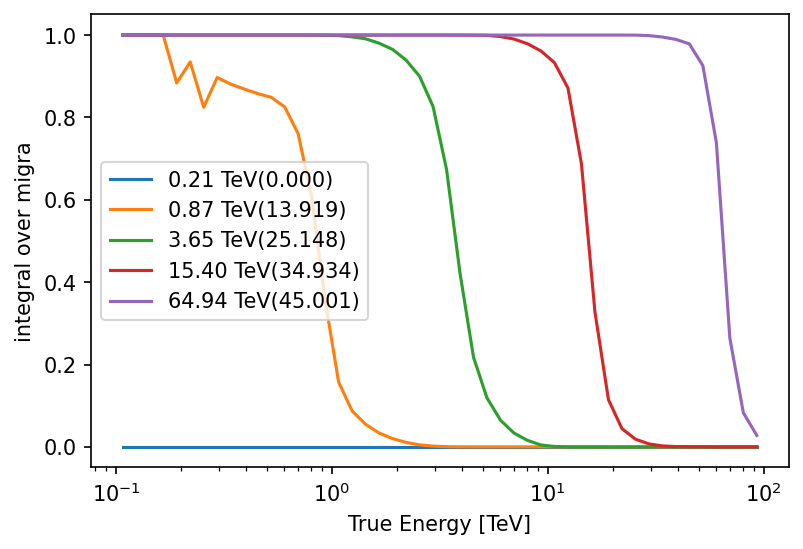

In [102]:
plt.figure(dpi=150)
for i in [5,15,25,35,45]:
    ker=values[:,i,3,3]
    plt.semilogx(energy_axis_true.center, ker, label=f"{energy_axis.edges[i]:.2f}({ker.sum():.3f})")
    
plt.legend()
plt.xlabel("True Energy [TeV]")
plt.ylabel("integral over migra")    

Text(0, 0.5, 'integral over migra')

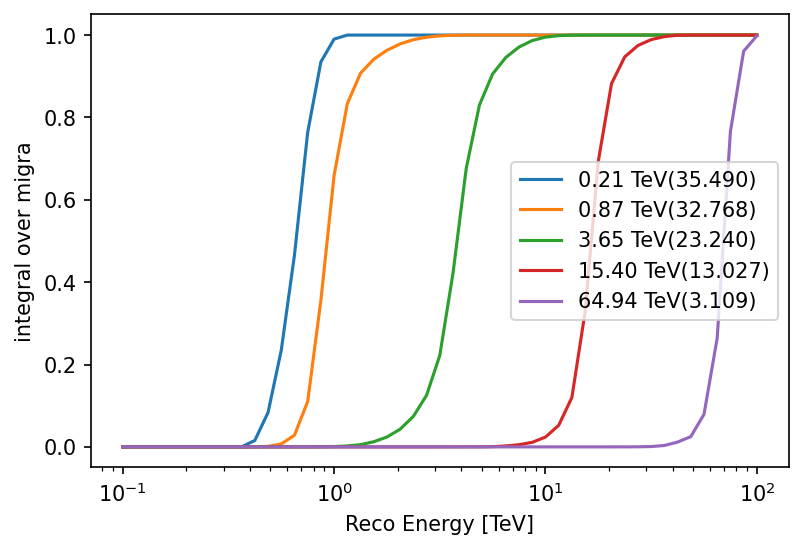

In [103]:
plt.figure(dpi=150)
for i in [5,15,25,35,45]:
    ker=values[i,:,3,3]
    plt.semilogx(energy_axis.edges, ker, label=f"{energy_axis_true.edges[i]:.2f}({ker.sum():.3f})")
    
plt.legend()
plt.xlabel("Reco Energy [TeV]")
plt.ylabel("integral over migra")    

Text(0, 0.5, 'integral over migra')

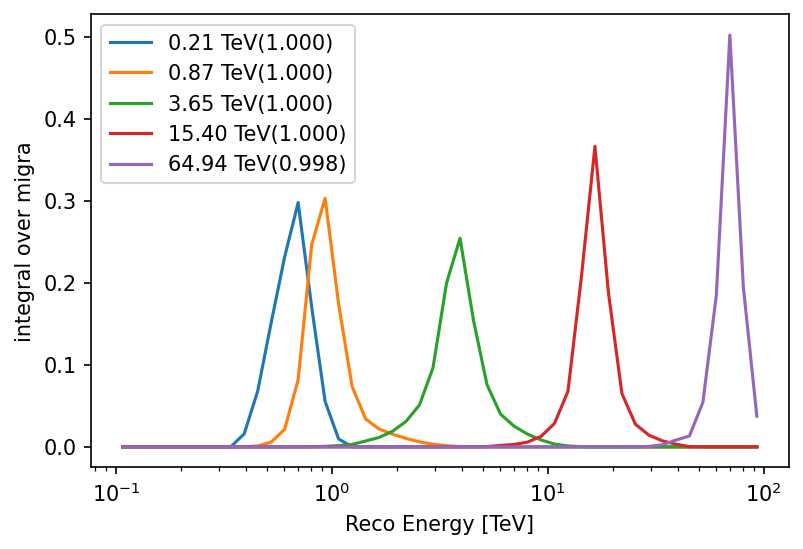

In [104]:
plt.figure(dpi=150)
for i in [5,15,25,35,45]:
    ker=data[i,:,3,3]
    plt.semilogx(energy_axis.center, ker, label=f"{energy_axis_true.edges[i]:.2f}({ker.sum():.3f})")
    
plt.legend()
plt.xlabel("Reco Energy [TeV]")
plt.ylabel("integral over migra") 

Text(0, 0.5, 'integral over migra')

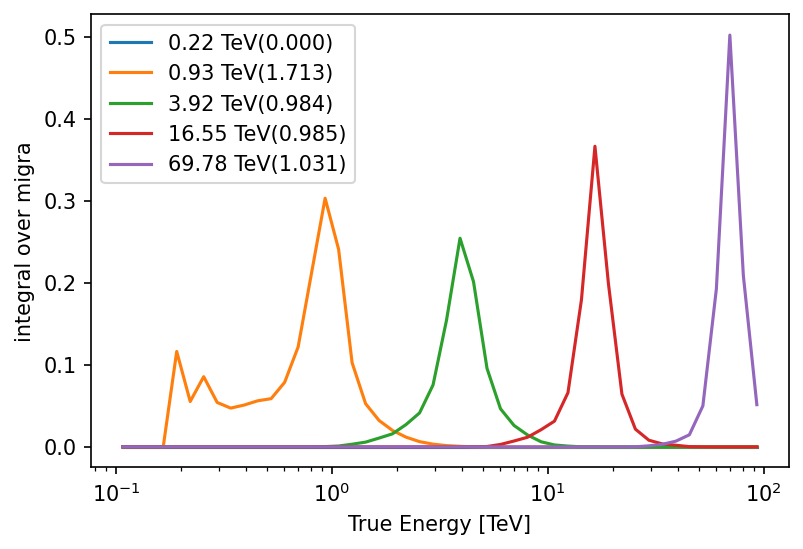

In [105]:
plt.figure(dpi=150)
for i in [5,15,25,35,45]:
    ker=data[:,i,3,3]
    plt.semilogx(energy_axis_true.center, ker, label=f"{energy_axis.center[i]:.2f}({ker.sum():.3f})")
    
plt.legend()
plt.xlabel("True Energy [TeV]")
plt.ylabel("integral over migra")  

In [106]:
data.shape

(48, 48, 7, 7)

In [107]:
values.shape

(48, 49, 7, 7)

<AxesSubplot:xlabel='True Energy [TeV]', ylabel='Energy [TeV]'>

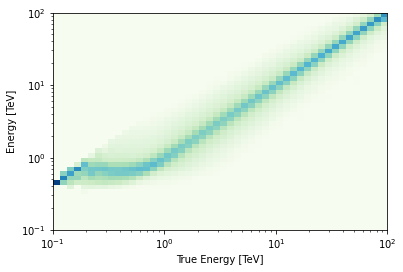

In [108]:
kernel_from_ds.plot_matrix()

In [109]:
kernel_from_ds.axes[1].center[16]

<Quantity 1.07460783 TeV>

Text(0.5, 0, 'energy_true [TeV]')

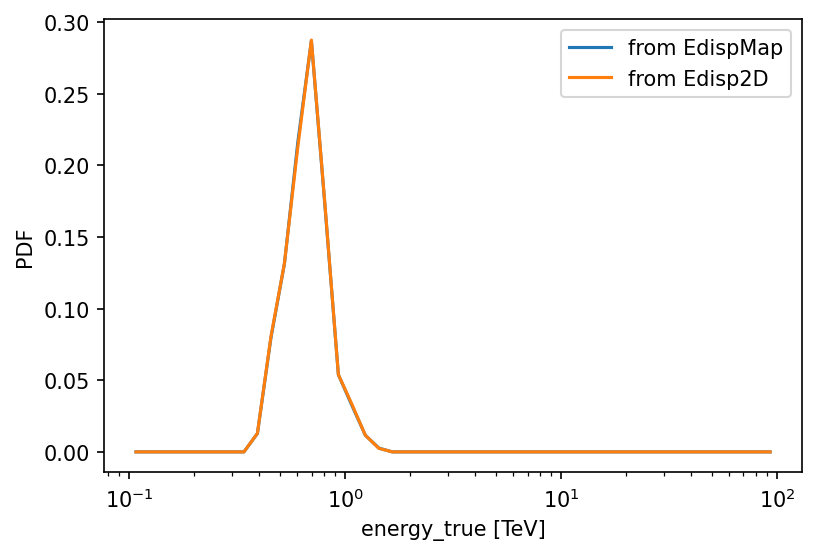

In [110]:
plt.figure(dpi=150)
plt.plot(energy_axis.center, kernel_from_ds.pdf_matrix[7,:], label='from EdispMap')
plt.plot(energy_axis.center, kernel_from_edisp2d.pdf_matrix[7,:], label='from Edisp2D')
plt.legend()
plt.semilogx()
plt.ylabel('PDF')
plt.xlabel('energy_true [TeV]')

## Compute the Edisp factors 
needed for the direct unbineed method

In [47]:
def make_edisp_factors(edisp2d, events, energy_axis_true, pointing, model_pos):
    # use event offsets for larger models + good psf, true offset is closer to event offset
    offsets = events.radec.separation(pointing)[:,None] 
    # use model offset for small models or bad psf, true offset is closer to model offset
    offset = model_pos.separation(pointing)
    
    event_migra = events.energy[:,None]/energy_axis_true.center
    
    # interpolate the edisp to the true energy axis, possibly even model offset
    mm,ee,oo = np.meshgrid(edisp2d.axes['migra'].center,
                           energy_axis_true.center,
                           edisp2d.axes['offset'].center)
    dmigra = edisp2d.axes['migra'].bin_width[:,None]
    data = edisp2d.evaluate(offset=oo, energy_true=ee, migra=mm, method='linear') 
    edisp = EnergyDispersion2D(axes=[energy_axis_true,edisp2d.axes['migra'],edisp2d.axes['offset']],
                               data=data, interp_kwargs = edisp2d.interp_kwargs)
    edisp.normalize() # not sure if we want to normalize here
    edisp.data *= dmigra.value # multiply with dmigra to get P
#     edisp.data /= energy_axis_true.center.value[:,None,None]
    values = edisp.evaluate(offset=offset,energy_true=energy_axis_true.center, migra=event_migra, method='linear')
    # cut by migra axis edges since we don't want extrapolation
    m_min, m_max = edisp2d.axes['migra'].edges[[0,-1]]
    mask = (event_migra < m_max) & (event_migra > m_min)
    return values*mask

def make_exposure_factors(aeff, pointing, model_pos, livetime, energy_axis_true):
    offset = pointing.separation(model_pos)
    return aeff.evaluate(offset=offset, energy_true=energy_axis_true.center) * livetime

In [12]:
model_gauss = SkyModel(
    spatial_model=GaussianSpatialModel(lon_0="184.557 deg", lat_0="-5.784 deg", sigma='0.016 deg', frame = 'galactic'),
    spectral_model=LogParabolaSpectralModel(amplitude='3.5e-11 cm-2 s-1 TeV-1', 
                                          reference='1 TeV', 
                                          alpha=1.8, 
                                          beta=0.4
                                         ),
    name='crab_model_gauss'
    )

model_gauss.spectral_model.amplitude.value /= 10. # 10 times weaker signal than the Crab

dataset.models=[model_gauss]

In [48]:
edisp2d= obs1.edisp
events = obs1.events.select_energy([1,50]*u.TeV)
events = events.select_offset([0.5,1]*u.deg)
offsets = events.radec.separation(obs_pos)[:,None] 
offset = obs_pos.separation(model_gauss.position)
event_e = events.energy

# compare to my inverse Edisp
edispI = EdispInv(edisp2d, event_e.min(), event_e.max())
edisp_factors = edispI.evaluate(offset = offset, energy=event_e[:,None], 
                                energy_true=energy_axis_true.center[None,:], method='linear')
edisp_factors.shape
# compare to the gammay EdispKernel (transposed)
ek = edisp2d.to_edisp_kernel(offset=offset, energy_true=energy_axis_true.edges, energy=energy_axis.edges)

In [49]:
test=make_edisp_factors(obs1.edisp,events, energy_axis_true, obs1.pointing_radec, model_gauss.position)
exp_fac = make_exposure_factors(obs1.aeff, obs_pos, 
                                model_gauss.position, 
                                obs1.fixed_pointing_info.duration, energy_axis_true)
# test.normalize()

In [55]:
# some timing test
%timeit make_edisp_factors(obs1.edisp,events, energy_axis_true, obs1.pointing_radec, model_gauss.position)

32.7 ms ± 165 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


0.21362776212472057 0.9747071239487712 0.6710581884251834
0.2474502627015222 1.1360927945797283 0.6677512756662323
0.2224820303370798 0.9960256112225971 0.6687937461729574


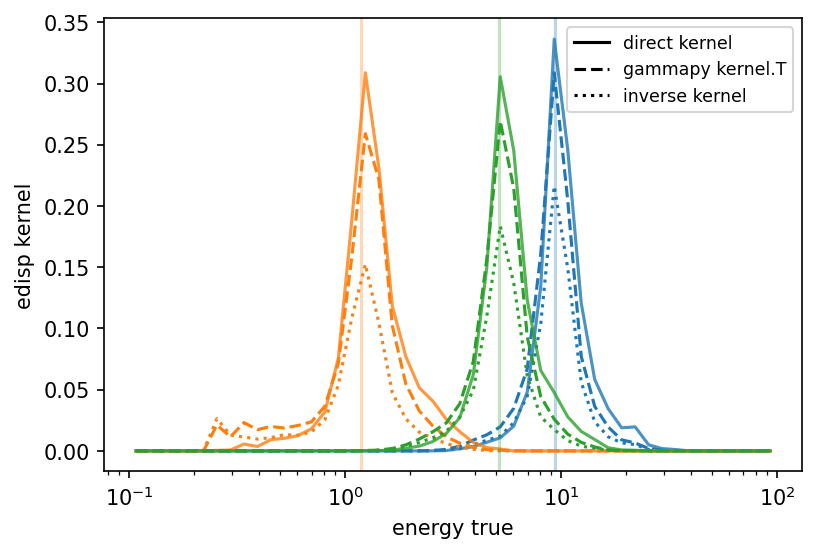

In [50]:
plt.figure(dpi=150)
for i in [50,52,54]:
    l=plt.semilogx(energy_axis_true.center, test[i,:]*5, alpha=0.8)
    c=l[0].get_color()
    plt.axvline(events.energy[i].value, c=c, alpha=0.3)
    
    idx=np.argmin(np.abs(events.energy[i]-energy_axis_true.center))
    plt.plot(energy_axis_true.center,ek.pdf_matrix[:,idx], color=c, ls='--')
    plt.plot(energy_axis_true.center,edisp_factors[i,:], color=c, ls=':')
    print(test[i,:].sum(), ek.pdf_matrix[:,idx].sum(), edisp_factors[i,:].sum())

plt.xlabel('energy true')
plt.ylabel("edisp kernel")
# plt.ylim(0,1)

plt.plot([],[],c='k', label='direct kernel')
plt.plot([],[],c='k', ls='--', label='gammapy kernel.T')
plt.plot([],[],c='k', ls=':', label='inverse kernel')
plt.legend(fontsize='small')

We see nice agreement in general. The factor with which the "test" kernel is scaled comes from the different sizes of Ereco bins. Once from energy_axis and from the migra bins. Also we expect that our method is more precise since it does not rely on reco binning but uses the precise migra bins directly. Also note that for the comparison with the gammapy kernel we don't interpolate to the precise Ereco but take the closest bin.

## now compare the response and interpolated npred

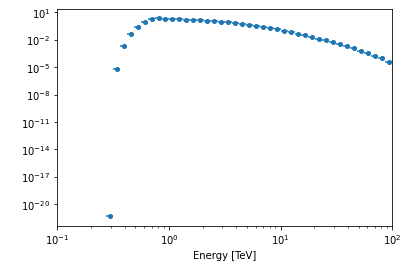

In [51]:
ds_spec=dataset.npred().get_spectrum()
ds_spec.plot()
response_ds = ds_spec.interp_by_coord(coords= events.map_coord(ds_spec.geom))

In [52]:
npred=model_gauss.integrate_geom(dataset.exposure.geom).get_spectrum()
response = (npred.data.flatten()*test*exp_fac.to_value(1/npred.unit)).sum(axis=1)

Text(0, 0.5, 'npred')

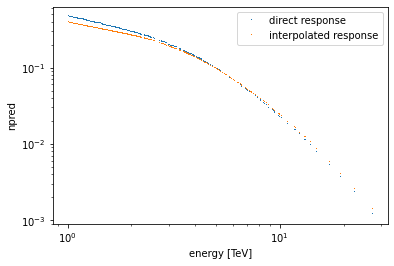

In [83]:
plt.loglog(events.energy, response, ls="None", marker=',', label='direct response')
plt.loglog(events.energy, response_ds/5, ls="None", marker=',', label='interpolated response')
# Also here the factor of 5 comes from different Ereco bin sizes which is expected and 
# not a problem since the likelihoods will not be sensitive to constants
plt.legend()
plt.xlabel("energy [TeV]")
plt.ylabel("npred")

Text(0, 0.5, 'interpolated response')

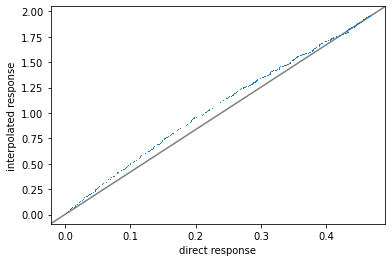

In [84]:
plt.plot(response, response_ds, ",")
plt.plot([0,1],[0,1], c='k', transform=plt.gca().transAxes, zorder=0, alpha=0.5)
plt.xlabel("direct response")
plt.ylabel("interpolated response")

Text(0, 0.5, 'interpolated response / direct response')

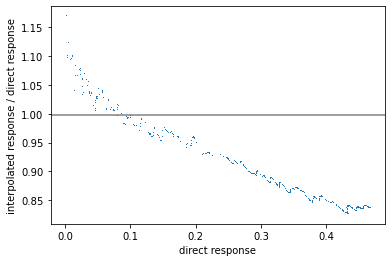

In [92]:
plt.plot(response, response_ds/response/5, ",")
plt.plot([0,1],[.5,.5], c='k', transform=plt.gca().transAxes, zorder=0, alpha=0.5)
plt.xlabel("direct response")
plt.ylabel("interpolated response / direct response")

### check if the exposure makes the difference

In [78]:
npred2=model_gauss.integrate_geom(dataset.evaluators['crab_model_gauss'].exposure.geom).get_spectrum()
response2 = (npred2.data*dataset.evaluators['crab_model_gauss'].exposure.quantity.to_value(1/npred.unit)).sum(axis=(1,2))
response2=(test*response2).sum(axis=1)

Text(0, 0.5, 'direct response (our exposure)')

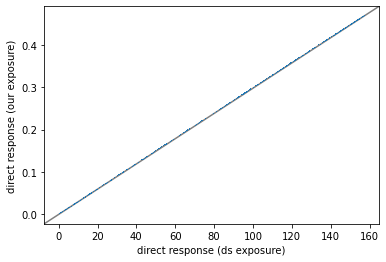

In [85]:
plt.plot(response2, response, ",")
plt.plot([0,1],[0,1], c='k', transform=plt.gca().transAxes, zorder=0, alpha=0.5)
plt.xlabel("direct response (ds exposure)")
plt.ylabel("direct response (our exposure)")

### check if the inverse Edisp performs different

In [86]:
response_inv = (npred.data.flatten()*edisp_factors*exp_fac.to_value(1/npred.unit)).sum(axis=1)

Text(0, 0.5, 'direct response (inv Edisp)')

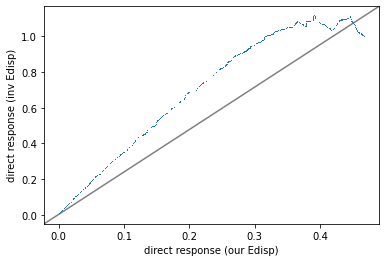

In [88]:
plt.plot(response, response_inv, ",")
plt.plot([0,1],[0,1], c='k', transform=plt.gca().transAxes, zorder=0, alpha=0.5)
plt.xlabel("direct response (our Edisp)")
plt.ylabel("direct response (inv Edisp)")

Text(0, 0.5, 'npred')

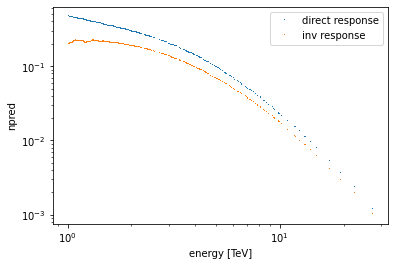

In [89]:
plt.loglog(events.energy, response, ls="None", marker=',', label='direct response')
plt.loglog(events.energy, response_inv/5, ls="None", marker=',', label='inv response')
# Also here the factor of 5 comes from different Ereco bin sizes which is expected and 
# not a problem since the likelihoods will not be sensitive to constants
plt.legend()
plt.xlabel("energy [TeV]")
plt.ylabel("npred")

Text(0, 0.5, 'interpolated response / direct response')

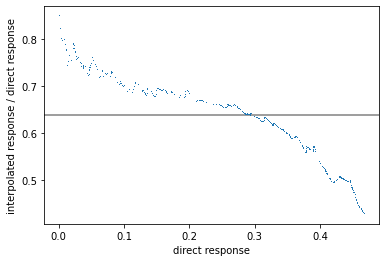

In [93]:
plt.plot(response, response_inv/response/5, ",")
plt.plot([0,1],[.5,.5], c='k', transform=plt.gca().transAxes, zorder=0, alpha=0.5)
plt.xlabel("direct response")
plt.ylabel("interpolated response / direct response")